In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<h2>Importing Libraries:<h2/>

In [ ]:
import json
import re
import nltk
import cv2
import datetime
import joblib
nltk.download('punkt')

import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow_hub as hub

from prettytable import PrettyTable
from nltk.tokenize import word_tokenize
from tqdm.notebook import tqdm
from prettytable import PrettyTable
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing import image
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import (
    Embedding, LSTM, SpatialDropout1D, Input, concatenate, Dense, Multiply, 
    BatchNormalization, Dropout
)
from tensorflow.keras.callbacks import (
    LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
)
from tensorflow.keras.applications import vgg16, resnet50
from tensorflow.keras.utils import plot_model

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<h2>Downloading and Extracting data:<h2/>

In [ ]:
!wget http://images.cocodataset.org/zips/train2014.zip
!wget https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Train_mscoco.zip
!wget https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Train_mscoco.zip

In [ ]:
!7z x train2014.zip -o*
!7z x v2_Questions_Train_mscoco.zip -o*
!7z x v2_Annotations_Train_mscoco.zip -o*

import shutil
shutil.rmtree("v2_Annotations_Train_mscoco")

import os
os.remove("train2014.zip")
os.remove("v2_Questions_Train_mscoco.zip")
os.remove("v2_Annotations_Train_mscoco.zip")

# Loading filtered data:

The below dataframe contains information about the samples whose answers belong to the top-100 most frequent one-word answers.

This filtering was done earlier during the EDA.

In [ ]:
# load the data
data_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-2-VQA/data.csv')
data_df.shape

(307568, 6)

In [ ]:
print("Number of unique answers: ", data_df['multiple_choice_answer'].nunique())

Number of unique answers:  100


# Sampling dataset:

- Due to resource constraints(compute and memory) working with full 300k+ points was expensive. Hence reducing the size to 50k points.

- This is done by splitting the data in a stratified way to maintain the same answer_type distribution.

In [ ]:
data_df, _ = train_test_split(
    data_df, train_size=int(5.e4), stratify=data_df['answer_type'], random_state=30)
data_df.shape

(50000, 6)

## Distribution of answer_types:

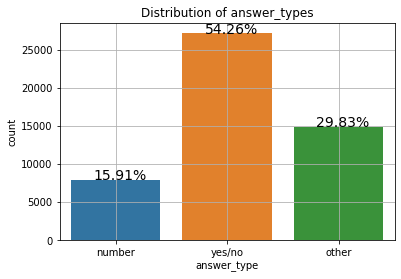

In [ ]:
ax = sns.countplot(data=data_df, x='answer_type')

# Annotating
for p in ax.patches:
    ax.annotate(
        '{:.2f}%'.format( 
        (p.get_height()/len(data_df))*100), 
        (p.get_x()+0.2, p.get_height()),
        size=14
    )

plt.title("Distribution of answer_types")
plt.grid()
plt.show()

# Cleaning textual data(Questions):

The annotations released has the following cleaning steps already done on the raw crowdsourced data:
- Spelling correction (using Bing Speller) of question and answer strings
- Question normalization (first char uppercase, last char ‘?’)
- Answer normalization (all chars lowercase, no period except as decimal point, number words —> digits, strip articles (a, an the))
- Adding apostrophe if a contraction is missing it (e.g., convert "dont" to "don't")

Source: [link](https://visualqa.org/download.html#:~:text=from%20here.-,Overview,-The%20annotations%20we)

### Removing Contractions and Cleaning text:

To remove contraction here I use a module called '[contractions](https://github.com/kootenpv/contractions)'. There are few other packages such '[pycontractions](https://pypi.org/project/pycontractions/)', etc which can also be used.

In [ ]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 287 kB 38.8 MB/s 
     |████████████████████████████████| 110 kB 97.7 MB/s 


Clean the questions by fixing contractions, lowering the text and removing any special characters.

In [ ]:
import contractions

def clean_text(text):
    """
    Clean the text by fixing contractions, lowering the text and removing 
    any special characters.
    """
    text = contractions.fix(text)
    text = text.lower()
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    return text

In [ ]:
data_df['question'] = data_df['question'].apply(lambda x: clean_text(x))
data_df['question'].sample(10)

45905           can that kite get stuck in the trees 
14435     is this veggie dish being prepared at home 
1489                       are there people watching 
117370    what color is the hardware on the cabinets 
121296                how many bookshelves are there 
66958                          is this a busy street 
247735                      is the man holding a gun 
289931                        what is inside the box 
154386                      what color are the roses 
237206          is that a harley davidson motorcycle 
Name: question, dtype: object

In [ ]:
# Saving the data
data_df.to_csv('/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-2-VQA/data_sampled.csv', index=False)
# load the data
data_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-2-VQA/data_sampled.csv')

# Train-Val Splitting:

The data is further split into 75% train and 25% validation split(also in a stratified way).

In [ ]:
train_df, val_df = train_test_split(
    data_df, train_size=0.8, stratify=data_df['answer_type'], random_state=30)

print("Shape of train data: ", train_df.shape)
print("Shape of validation data: ", val_df.shape)

Shape of train data:  (40000, 6)
Shape of validation data:  (10000, 6)


In [ ]:
# Saving the train data
train_df.to_csv('/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-2-VQA/train_df.csv', index=False)
# load the train data
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-2-VQA/train_df.csv')

# Saving the val data
val_df.to_csv('/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-2-VQA/val_df.csv', index=False)
# load the val data
val_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-2-VQA/val_df.csv')

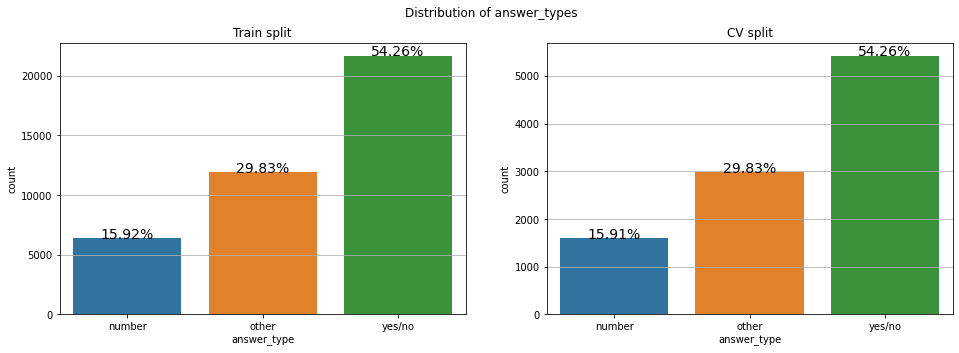

In [ ]:
plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
plt.grid()
plt.title("Train split")
ax = sns.countplot(data=train_df, x='answer_type', order=np.unique(train_df['answer_type']))

# Annotating
for p in ax.patches:
    ax.annotate(
        '{:.2f}%'.format( 
        (p.get_height()/len(train_df))*100), 
        (p.get_x()+0.2, p.get_height()),
        size=14
    )

plt.subplot(1,2,2)
plt.grid()
plt.title("CV split")
ax = sns.countplot(data=val_df, x='answer_type', order=np.unique(train_df['answer_type']))

# Annotating
for p in ax.patches:
    ax.annotate(
        '{:.2f}%'.format( 
        (p.get_height()/len(val_df))*100), 
        (p.get_x()+0.2, p.get_height()),
        size=14
    )

plt.suptitle("Distribution of answer_types")
plt.show()

In [ ]:
print("Number of unique answers in train set: ", train_df['multiple_choice_answer'].nunique())

Number of unique answers in train set:  100


# Sequence length of questions:

In [ ]:
# calculating the count of words for every question in train data
question_word_count = train_df['question'].apply(
    lambda x: len(word_tokenize(x)))

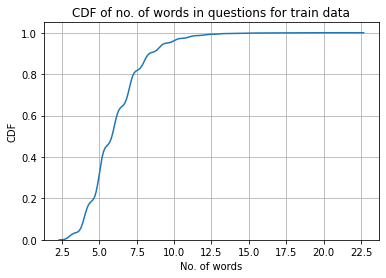

In [ ]:
sns.kdeplot(question_word_count, cumulative=True, label="cdf")
plt.title("CDF of no. of words in questions for train data")
plt.xlabel("No. of words")
plt.ylabel("CDF")
plt.grid()
plt.show()

In [ ]:
print("Min no. of words: ", min(question_word_count))
print("Max no. of words: ", max(question_word_count))

x = PrettyTable()
x.field_names = ["Percentile", "No. of words"]

for i in range(95,101,1):
    x.add_row([i,np.round(np.percentile(question_word_count,i), 3)])
print(x)

Min no. of words:  3
Max no. of words:  22
+------------+--------------+
| Percentile | No. of words |
+------------+--------------+
|     95     |     9.0      |
|     96     |     10.0     |
|     97     |     10.0     |
|     98     |     11.0     |
|     99     |     12.0     |
|    100     |     22.0     |
+------------+--------------+


**Observations:**
- 99% of all questions have no. of words below 12.
- Max no. of words among all the questions is 22. Since 22 is still a small number this can be used as the max sequence length in further steps of model building such as sequence length for embedding layer. etc

In [ ]:
MAX_SEQUENCE_LENGTH = 22

# One-Hot Encode answers:

In [ ]:
ohe=OneHotEncoder(sparse=False)
ohe.fit(train_df['multiple_choice_answer'].values.reshape(-1,1))

OneHotEncoder(sparse=False)

In [ ]:
print("Number of answers: ", len(ohe.categories_[0]))
print("Answers: ", ohe.categories_)

Number of answers:  100
Answers:  [array(['0', '1', '10', '11', '12', '2', '20', '3', '4', '5', '6', '7',
       '8', '9', 'apple', 'banana', 'baseball', 'bathroom', 'beach',
       'bear', 'black', 'blue', 'brick', 'broccoli', 'brown', 'bus',
       'cake', 'camera', 'car', 'cat', 'clear', 'cow', 'dog', 'donut',
       'eating', 'elephant', 'female', 'flowers', 'food', 'frisbee',
       'giraffe', 'grass', 'gray', 'green', 'hat', 'horse', 'kitchen',
       'kite', 'laptop', 'left', 'male', 'man', 'many', 'metal',
       'motorcycle', 'no', 'none', 'nothing', 'orange', 'outside',
       'phone', 'pink', 'pizza', 'plane', 'purple', 'red', 'right',
       'sandwich', 'sheep', 'silver', 'sitting', 'skateboard',
       'skateboarding', 'skiing', 'snow', 'snowboarding', 'soccer',
       'standing', 'stop', 'summer', 'sunny', 'surfboard', 'surfing',
       'table', 'tan', 'tennis', 'tile', 'train', 'trees', 'umbrella',
       'walking', 'water', 'white', 'wii', 'wine', 'winter', 'woman',
   

In [ ]:
# saving One-Hot Encoder
joblib.dump(ohe, "/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-2-VQA/featurizers/ohe.joblib")
ohe = joblib.load("/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-2-VQA/featurizers/ohe.joblib")

# Modeling:

Solving the VQA problem involves four major steps:

- Image featurization: Encoding the information in the image.
- Question featurization: Encoding the information in the natural language questions.
- Joint feature representation: Combining/Fusing the information/features from both the image and the question.
- Answer generation: Generating natural language answers utilizing the features generated.

Reference: https://blog.paperspace.com/introduction-to-visual-questionanswering/

## Simple variants of the vanilla VQA model:

As explained earlier the vanilla VQA model is generic and many simple variants of the vanilla VQA model can be obtained by using different techniques at each step.

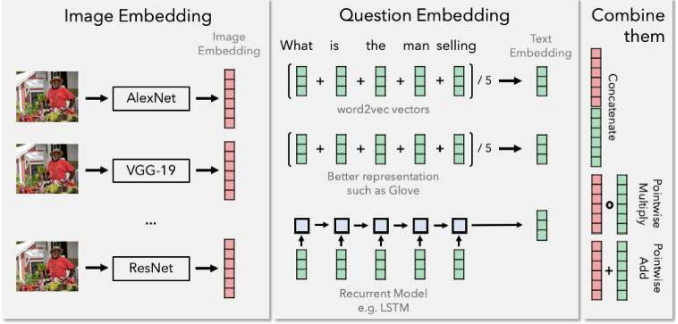

Source: https://blog.allenai.org/vanilla-vqa-adcaaaa94336

For this case study, we can experiment with the below 2 combinations for obtaining the image and text embeddings:
1. **Model-1**: VGG16 to featurize the image and LSTM with Glove word embeddings
to featurize the questions.
2. **Model-2**: ResNet50 to featurize the image and BERT embeddings to featurize the questions. 


**Note:**
Since the model is posed as a simple k-class classification problem the regular accuracy metric is used for evaluation while model training. 

Additionally, the model also can be evaluated using the modified accuracy metric that was defined earlier in the 'Intro_and_EDA' notebook. 

## Callbacks for model training:


### LearningRateScheduler: 

- Reduce by 5% for every 3rd epoch

In [ ]:
def changeLearningRate(epoch, lr):
    if ((epoch+1) % 3)==0:
        changed_lr = (lr - (lr*0.05))
        return changed_lr
    else:
        return lr

lrschedule = LearningRateScheduler(changeLearningRate, verbose=1)

- Reduce by 10% if validation Acc at that epoch is not less than previous epoch Acc

In [ ]:
reduce_lr_on_acc = ReduceLROnPlateau(factor=0.9, monitor='val_accuracy', patience=1, verbose=1, mode='max') 
#new_lr = lr*factor in ReduceLROnPlateau, so to reduce lr by 10%: new_lr=lr-(lr*0.1)=lr(1-0.1)=lr*0.9

### Callback to terminate training if loss or weights is 'NaN':

In [ ]:
class TerminateNaN(tf.keras.callbacks.Callback):
        
    def on_epoch_end(self, epoch, logs={}):
        loss = logs.get('loss')
        if loss is not None:
            if np.isnan(loss) or np.isinf(loss):
                print("Invalid loss and terminated at epoch {}".format(epoch))
                self.model.stop_training = True

        weights= self.model.get_weights()
        for i in weights:
            if np.isnan(np.sum(i)):
                print("Invalid weights and terminated at epoch {}".format(epoch))
                self.model.stop_training = True

terminate_nan = TerminateNaN()

### EarlyStopping:
Stop the training if validation accuracy is not increased in last 5 epochs

In [ ]:
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max')

## Model-1:
VGG16 to featurize the image and LSTM with Glove word embeddings to featurize the questions.

### Helpers to Embed questions:

**1. Creating Tokenizer using the train data to learn the vocabulary:**

This tokenizer will be used for converting text(questions) to sequence of integers

In [ ]:
# out of vocabulary tokens are replaced with 'oov_token' to give an int value to such oov tokens (in my case for words that were not in train data)
tknizr = Tokenizer(oov_token='oov_token') 
# fit on train data
tknizr.fit_on_texts(train_df['question'])
# indices for each of the word in the vocab
WORD_INDEX = tknizr.word_index
# vocab size (no. of all tokens in the text(questions) train data)
# +1 is used below because all the indices we get are starting from 1 but after padding we also add 0 so total=len(word_index)+1
VOCAB_SIZE = len(WORD_INDEX) + 1 
print('Found %s unique tokens.' % len(WORD_INDEX))

Found 6170 unique tokens.


In [ ]:
print("Question: ", train_df.iloc[0]['question'])
print("\nExample encoding of text to ints using tf's Tokenizer: ", 
      tknizr.texts_to_sequences(train_df.iloc[0:1]['question'])[0])

Question:  is the person snowboarding 

Example encoding of text to ints using tf's Tokenizer:  [3, 2, 25, 593]


In [ ]:
# saving Tokenizer
joblib.dump(tknizr, "/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-2-VQA/featurizers/tknizr.joblib")
tknizr = joblib.load("/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-2-VQA/featurizers/tknizr.joblib")

**2. Creating Embedding Layer to featurize questions:**

- **Creating Embedding Matrix from words in train data and GLOVE word embeddings:**

This will be used as weights for Embedding layer while model building

In [ ]:
# downloading GLOVE word embeddings and unzipping
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2022-12-17 17:52:39--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-12-17 17:52:40--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-12-17 17:52:40--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

As seen in the above files, there are diferent embedding sizes: 50d, 100d, 200d, 300d.

For this case study, 300d word vectors are used.

In [ ]:
# load the whole GLOVE embedding into memory
# Ref: https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
EMBEDDING_DIM = 300

embeddings_index = dict()
f = open('./glove.6B.300d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()

print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [ ]:
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
for word, i in WORD_INDEX.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    # else:
    #     # words not found in embedding index will be average of all vectors Ref:# https://stackoverflow.com/a/53717345
    #     embedding_matrix[i] = average_glove_vector

- **Creating an Embedding Layer with weights from GLOVE embedding matrix:**

This embedding layer will be used for embedding text(questions) data. 

In [ ]:
# making the Embedding layer non-trainable using trainable=False, 
# since the GLOVE word embeddings are already a result of well trained process.

glove_embedding_layer = Embedding(
    VOCAB_SIZE, EMBEDDING_DIM, weights=[embedding_matrix], 
    input_length=MAX_SEQUENCE_LENGTH, name='GLOVE_embedding_layer', 
    trainable=False
)

When using the tf.keras Embedding layer, the input needs to be of same length. Hence, the textual data will be padded to the MAX_SEQUENCE_LENGTH(22) decided earlier

**3. Encode text(questions):**

- The text data is cleaned as discussed earlier in [this](#scrollTo=Pvq1v1UTZX-f) section.
- The text data is tokenized and converted to sequence of ints.
- The sequence is padded to a common sequence length(MAX_SEQUENCE_LENGTH).
- Finally encoded using the Embedding layer created above.<br />
The shape of the encoded data from embedding layer should be: `(None, MAX_SEQUENCE_LENGTH(22), 300)`

In [ ]:
def encode_questions_model_1(tknizr, embd_layer, text, seq_len):
    """Encode text data.

    Parameters:
    -----------
    tknizr: tensorflow.keras.preprocessing.text.Tokenizer
        Tokenizer to convert text to int sequences.

    embd_layer: tensorflow.keras.layers.Embedding
        tf keras Embedding layer to embed sequence.

    text: str
        Question to encode.
    
    seq_len: int
        max sequence length to pad the sequence to.

    Returns:
    --------
    encoded_sequence: tf.Tensor
        Encoded text sequence
    """
    # clean the text
    text = clean_text(text)
    # converting to int sequences using the tokenizer
    encoded_seq = tknizr.texts_to_sequences([text]) # need to pass list of values
    # padding sequences to seq_len
    encoded_seq = pad_sequences(
        encoded_seq, maxlen=seq_len, dtype='int32', padding='post'
    )
    # embed using the Embedding layer with Glove embeddings as weights
    encoded_seq = embd_layer(encoded_seq)

    return encoded_seq

### Helpers to Embed Images:

**1. Preprocessing Images:**
- The images are loaded to a target size of (height, width) = (224, 224) which is the default value of [tf.keras.applications.vgg16.VGG16](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16). 
    
    It can be changed if necessary to any other suitable number(for ex: mean height and mean width of the images in the dataset). For this case study, the default values are used.
- The images are converted from RGB to BGR, then each color channel is zero-centered with respect to the ImageNet dataset, without scaling. This is achieved using the [tf.keras.applications.vgg16.preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/preprocess_input) function.

In [ ]:
IMG_TARGET_SIZE = (224, 224)

In [ ]:
def preprocess_images_model_1(img_path, target_size):
    """Preprocess images.

    Parameters:
    -----------
    img_path: str 
        Path to image file

    target_size: tuple(height, width)
        Size to load the image.

    Returns:
    --------
    img_arr: np.ndarray
        Preprocessed image as np array
    """
    img = image.load_img(img_path, target_size=target_size)
    img_arr = image.img_to_array(img)
    # The images are converted from RGB to BGR, 
    # then each color channel is zero-centered with respect to the ImageNet dataset, 
    # without scaling.
    img_arr = vgg16.preprocess_input(img_arr)
    
    return img_arr

**2. Creating a VGG16 model to featurize images:**

The activations from the last hidden layer of VGGNet are used as 4096-dim image embedding.

In [ ]:
# making the VGG16 non-trainable using trainable=False, 
# Since below I use pretrained model weights. 
# The weights obtained are a result of training on 'imagenet' dataset. 
vgg16_model = vgg16.VGG16(
    weights='imagenet', 
    #`input_shape` must be a tuple of three integers. The input must have 3 channels if weights = 'imagenet'
    input_shape=IMG_TARGET_SIZE+ (3,), 
)
vgg16_model.trainable = False

# Create a model that outputs activations from vgg16's last hidden layer
vgg_featurizer = Model(
    inputs=vgg16_model.inputs, outputs=vgg16_model.layers[-2].output)
vgg_featurizer.trainable = False

vgg_featurizer.summary()

553467096/553467096 [==============================] - 24s 0us/step
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                         

**3. Encode images:**

- The images are preprocessed as discussed earlier in [this](#scrollTo=0eKxUpXd6TjX&line=2&uniqifier=1) section and converted to numpy array.
- It is then encoded using the vgg_featurizer created above.<br />
The shape of the encoded data from vgg_featurizer should be: `(None, 4096)`

In [ ]:
def encode_images_model_1(vgg_featurizer, img_path, target_size):
    """Encode image data.

    Parameters:
    -----------
    vgg_featurizer: tensorflow.keras.models.Model
       Model from which the activations of last hidden layer in vgg16 can be extracted.

    img_path: str
        Path to image file.
    
    target_size: tuple(height, width)
        Size to load the image.

    Returns:
    --------
    vgg_feats: tf.Tensor
        Activations from last hidden layer of vgg16 model.
    """
    # preprocess the image
    img_arr = preprocess_images_model_1(img_path, target_size)
    # vgg_featurizer
    vgg_feats = vgg_featurizer(np.expand_dims(img_arr, axis=0))
    
    return vgg_feats

### Creating DataLoaders for model training and validation:

In [ ]:
class Dataset_model_1:
    def __init__(self, data, tknizer, embd_layer, max_len, vgg_featurizer, img_target_size, ohe):
        self.length = len(data)
        self.questions = data['question'].values
        self.tknizer = tknizer
        self.embd_layer = embd_layer
        self.max_len = max_len
        self.images = data['image_path'].values
        self.vgg_featurizer = vgg_featurizer
        self.img_target_size = img_target_size
        self.answers = data['multiple_choice_answer'].values
        self.ohe = ohe
 
    def __getitem__(self, i):
        # encode the questions using the "encode_questions_model_1" funtion defined earlier
        enc_seq = encode_questions_model_1(
            self.tknizer, self.embd_layer, self.questions[i], self.max_len)[0]
        # encode the images using the "encode_images_model_1" funtion defined earlier
        vgg_feats = encode_images_model_1(
            self.vgg_featurizer, self.images[i], self.img_target_size)[0]
        # one-hot encode answer
        ohe_answer = self.ohe.transform(np.asarray([[self.answers[i]]]))[0]
        
        return enc_seq, vgg_feats, ohe_answer
 
    def __len__(self): # The model.fit_gen requires this function
        return self.length

In [ ]:
#https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence  
class DataLoader(tf.keras.utils.Sequence):  
    def __init__(self, dataset, batch_size=1, shuffle=True, shuffle_every_epoch=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.shuffle_every_epoch = shuffle_every_epoch
        self.indexes = np.arange(len(dataset))
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

    def __getitem__(self, i):
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[self.indexes[j]])
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]

        return tuple([[batch[0],batch[1]],batch[2]])
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle_every_epoch:
            self.indexes = np.random.permutation(self.indexes)

In [ ]:
# creating train and validation dataset
train_dataset = Dataset_model_1(
    train_df, tknizr, glove_embedding_layer, MAX_SEQUENCE_LENGTH, 
    vgg_featurizer, IMG_TARGET_SIZE, ohe
)
val_dataset  = Dataset_model_1(
    val_df, tknizr, glove_embedding_layer, MAX_SEQUENCE_LENGTH, 
    vgg_featurizer, IMG_TARGET_SIZE, ohe
)

BATCH_SIZE = 512

# creating data loaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle_every_epoch=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle_every_epoch=True)

In [ ]:
feats, ans = train_dataloader[0]
img_feats, ques_feats = feats
print("Batch shape of image features: ", img_feats.shape)
print("Batch shape of question features: ", ques_feats.shape)
print("Batch shape of one-hot encoded answers: ", ans.shape)

Batch shape of image features:  (512, 22, 300)
Batch shape of question features:  (512, 4096)
Batch shape of one-hot encoded answers:  (512, 100)


### Model training:

#### Tensorboard Callback: 

In [ ]:
log_dir="/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-2-VQA/model_logs/model_1/"
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True, write_images=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)

#### ModelCheckpoint Callback:

Save the model after every epoch. You can check documentation <a href="https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint">here

In [ ]:
filepath="/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-2-VQA/model_save/best_model_1.h5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',  verbose=1, save_best_only=True, mode='max')

In [ ]:
# Clear any logs from previous runs
!rm -rf '/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-2-VQA/model_logs/model_1/'

In [ ]:
# MODEL 1

# ==============================================================================
#                           Operate on text features    
# ==============================================================================
ques_input = Input(
    shape=(MAX_SEQUENCE_LENGTH, EMBEDDING_DIM), name='glove_embedding')
print(ques_input.get_shape())

# Pass the embeddings from above to a two-layer LSTM
lstm_1 = LSTM(512, return_sequences=True, return_state=True, name="lstm_1")
whole_seq_output_1, final_memory_state_1, final_carry_state_1 = lstm_1(ques_input)
print(whole_seq_output_1.get_shape(), 
      final_memory_state_1.get_shape(), 
      final_carry_state_1.get_shape()
)

lstm_2 = LSTM(512, return_sequences=True, return_state=True, name="lstm_2")
_, final_memory_state_2, final_carry_state_2 = lstm_2(whole_seq_output_1)
print(final_memory_state_2.get_shape(), final_carry_state_2.get_shape())

# Concatenate cell states and hidden states from the above two LSTMs
concatenated_features = concatenate(
    inputs=[final_carry_state_1, final_memory_state_1, 
            final_carry_state_2, final_memory_state_2],
    name='concatenate'
)
print(concatenated_features.get_shape())    

ques_features = Dense(
    1024, activation='relu', name='ques_dense', 
    kernel_initializer=tf.keras.initializers.he_normal(seed=33)
)(concatenated_features)
print(ques_features.get_shape())    

# ==============================================================================
#                           Operate on image features    
# ==============================================================================
img_input = Input(shape=(4096,), name='vgg_activations')
print(img_input.get_shape())

l2_normed_vgg16_features = tf.math.l2_normalize(
    img_input, axis=1, epsilon=1e-12, name='l2_norm'
)
print(l2_normed_vgg16_features.get_shape())

img_features = Dense(
    1024, activation='relu', name='img_dense',
    kernel_initializer=tf.keras.initializers.he_normal(seed=36),
)(l2_normed_vgg16_features)
print(img_features.get_shape())

# ==============================================================================
#                           Joining Question and Image features
# ==============================================================================
joint_feat_rep = Multiply(
    name='pointwise-multiplication')([ques_features, img_features])
print(joint_feat_rep.get_shape())

# ==============================================================================
#                           Answer Generation
# ==============================================================================
batch_norm_1 = BatchNormalization(name='batch_norm_1')(joint_feat_rep)
drop_out_1 = Dropout(0.3, name='dropout_1')(batch_norm_1)
d2=Dense(
    512, activation='relu', name='dense_1', 
    kernel_initializer=tf.keras.initializers.he_normal(seed=39))(drop_out_1)

batch_norm_2 = BatchNormalization(name='batch_norm_2')(d2)
drop_out_2 = Dropout(0.1, name='dropout_2')(batch_norm_2)
d3=Dense(
    256, activation='relu', name='dense_2', 
    kernel_initializer=tf.keras.initializers.he_normal(seed=30))(drop_out_2)

final_output = Dense(
    100, activation='softmax', name='softmax_classification', 
    kernel_initializer=tf.keras.initializers.glorot_uniform(seed=3))(d3)
print(final_output.get_shape())

# ==============================================================================
model_1 = Model(inputs=[ques_input, img_input], outputs=final_output)
print(model_1.summary())

model_1.compile(
    loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model_1.fit(
    train_dataloader, steps_per_epoch=30, epochs=22, 
    validation_data=val_dataloader, validation_steps=10, 
    callbacks=[lrschedule, reduce_lr_on_acc, terminate_nan, earlystop, 
               tensorboard_callback, checkpoint]
)

(None, 22, 300)
(None, 22, 512) (None, 512) (None, 512)
(None, 512) (None, 512)
(None, 2048)
(None, 1024)
(None, 4096)
(None, 4096)
(None, 1024)
(None, 1024)
(None, 100)
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 glove_embedding (InputLayer)   [(None, 22, 300)]    0           []                               
                                                                                                  
 lstm_1 (LSTM)                  [(None, 22, 512),    1665024     ['glove_embedding[0][0]']        
                                 (None, 512),                                                     
                                 (None, 512)]                                                     
                                                                                                  
 lstm_2 (LSTM)       

In [ ]:
os.mkdir('/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-2-VQA/model_images')

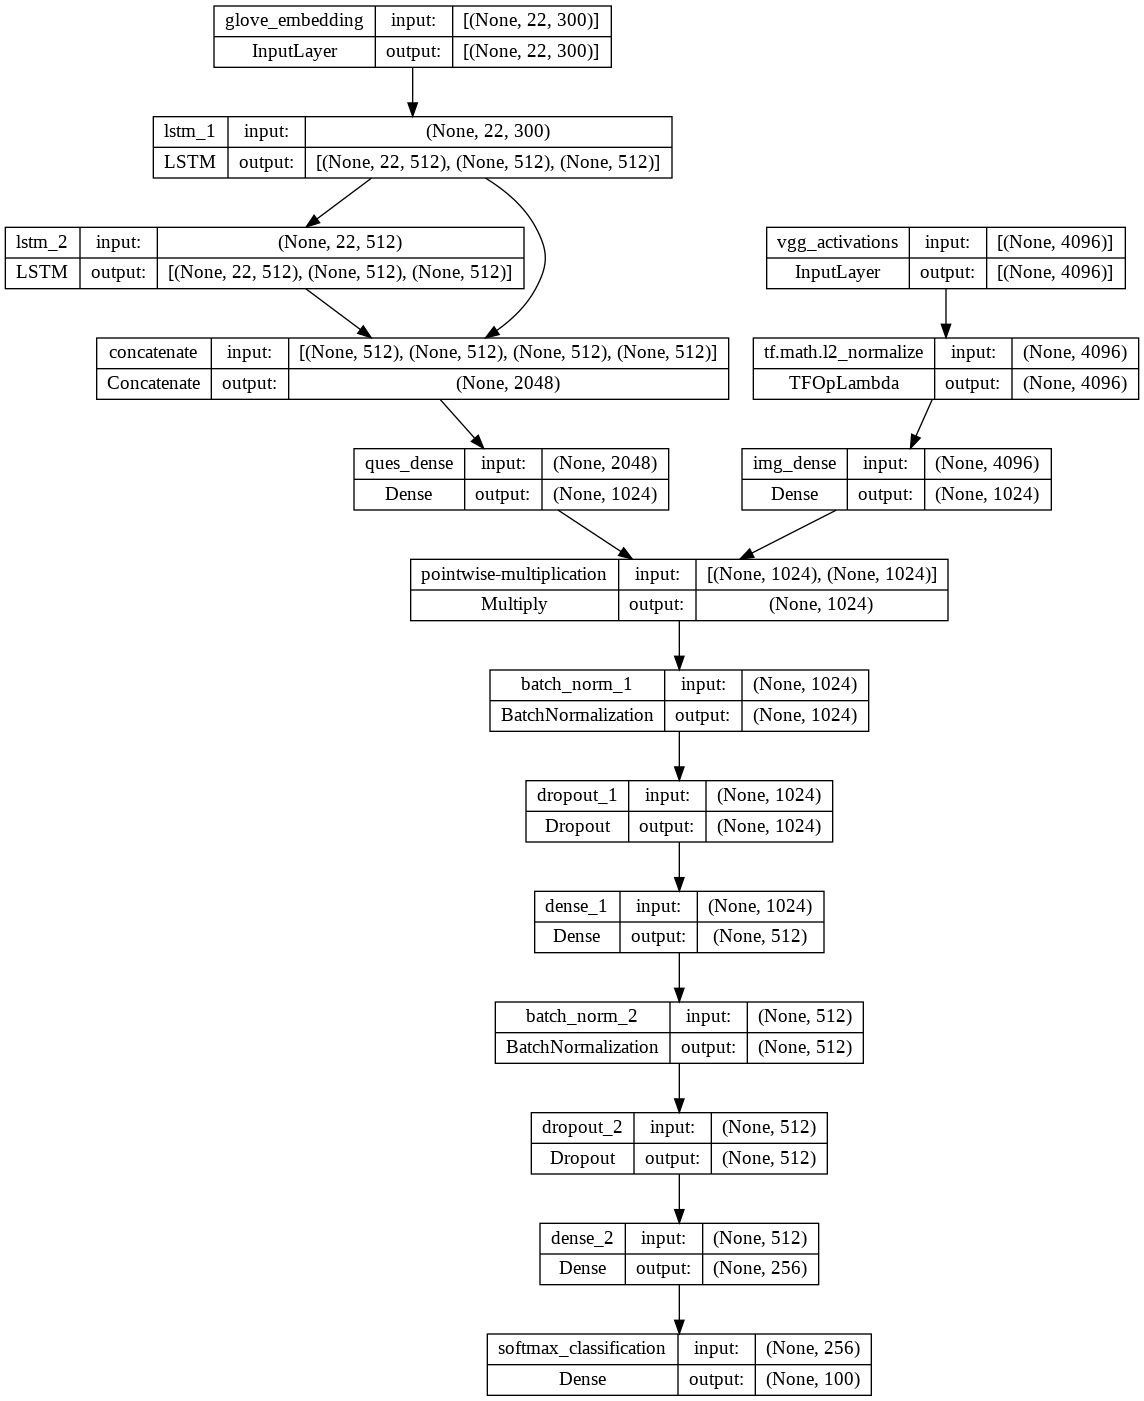

In [ ]:
dot_img_file = '/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-2-VQA/model_images/model_1.png'
plot_model(model_1, to_file=dot_img_file, show_shapes=True)

In [ ]:
model_1 = load_model('/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-2-VQA/model_save/best_model_1.h5')

In [ ]:
loss, accuracy = model_1.evaluate(val_dataloader, verbose=0)

In [ ]:
print("Val Loss: {}".format(loss))
print("Val Accuracy: {}".format(accuracy))

Val Loss: 1.3916805982589722
Val Accuracy: 0.4387335479259491


In [ ]:
# %tensorboard --logdir '/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-2-VQA/model_logs/model_1/'

Tensorboard logs: ( orange- Train, blue- Val )

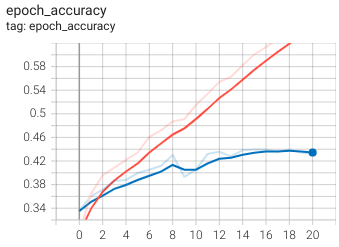

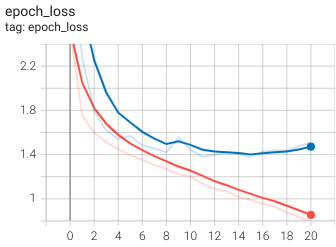

### Sample Prediction:

In [ ]:
y_pred_val = model_1.predict([np.asarray([val_dataset[1000][0]]), np.asarray([val_dataset[1000][1]])])
y_pred_val = ohe.inverse_transform(tf.one_hot(tf.argmax(y_pred_val, axis=1), depth=len(ohe.categories_[0])))[0][0]

1/1 [==============================] - 0s 17ms/step


(-0.5, 639.5, 426.5, -0.5)

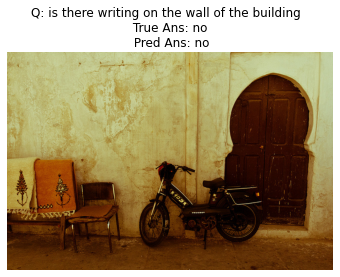

In [ ]:
plt.figure()
plt.title(
    f"Q: {val_df.iloc[1000]['question']} \n True Ans: {val_df.iloc[1000]['multiple_choice_answer']} \n Pred Ans: {y_pred_val}")
img = mpimg.imread(val_df.iloc[1000]['image_path'])
plt.imshow(img)
plt.axis('off')

## Model-2:
ResNet50 to featurize the image and BERT embeddings to featurize the questions.

### Helpers to Embed questions:

**1. Creating BERT Model to featurize questions:**

For this case study, we are using [BERT uncased Base model](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1). 

It uses L=12 hidden layers (i.e., Transformer blocks), a hidden size of H=768, and A=12 attention heads. 

In [ ]:
# maximum length of a seq in the data we have, for now i am making it as 22. You can change this
# (the max length of sequence that can be passed to Bert is 512)
max_seq_length = MAX_SEQUENCE_LENGTH

# BERT takes 3 inputs:

# this is input words. Sequence of words represented as integers
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
# mask vector if you are padding anything
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
# segment vectors. If you are giving only one sentence for the classification, total seg vector is 0. 
# If you are giving two sentenced with [sep] token separated, first seq segment vectors are zeros and 
# second seq segment vector are 1's
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

# bert layer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

# Bert model
# We are using only pooled output not sequence out. 
# If you want to know about those, please read https://www.kaggle.com/questions-and-answers/86510
bert_featurizer = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)

In [ ]:
bert_featurizer.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 22)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 22)]         0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 22)]         0           []                               
                                                                                                  
 keras_layer_1 (KerasLayer)     [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 22, 768)]                 'input_mask[0][0]',       

In [ ]:
bert_featurizer.input

[<KerasTensor: shape=(None, 22) dtype=int32 (created by layer 'input_word_ids')>,
 <KerasTensor: shape=(None, 22) dtype=int32 (created by layer 'input_mask')>,
 <KerasTensor: shape=(None, 22) dtype=int32 (created by layer 'segment_ids')>]

In [ ]:
bert_featurizer.output

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer_1')>

**2. Tokenizing text(questions) and creating input vectors required by bert_featurizer.**

The below tokenizer file will be used for converting text(questions) to the necessary format required for the BERT model.

Src: https://github.com/google-research/bert/blob/master/tokenization.py

In [ ]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-2-VQA/')
!ls

'1. Intro and EDA.ipynb'		      model_2
'2. Preprocessing and Model Training.ipynb'   model_images
'3. Final.ipynb'			      model_logs
 best_model_2.h5			      model_save
 data.csv				      __pycache__
 data_sampled.csv			      tokenization.py
 featurizers				      train_df.csv
 glove.6B.300d.txt			      val_df.csv


In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 27.1 MB/s 


In [ ]:
# import tokenization - The tokenization.py file can be found here: https://github.com/google-research/bert/blob/master/tokenization.py
from featurizers import tokenization

In [ ]:
os.chdir('../../../../../..')
!ls

drive  sample_data  train2014  v2_Questions_Train_mscoco


In [ ]:
#getting Vocab file
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

In [ ]:
# Create tokenizer "Instantiate FullTokenizer" 
# the FullTokenizer takes two parameters 1. vocab_file and 2. do_lower_case 
# we have created these in the above cell ex: FullTokenizer(vocab_file, do_lower_case )
# please check the "tokenization.py" file the complete implementation

tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

When using the BERT model, the input needs to be of same length. Hence, the textual data will be padded to the MAX_SEQUENCE_LENGTH(22) decided earlier

In [ ]:
# Create train and test tokens (train_tokens, test_tokens) from (train, test) using Tokenizer and 
# add '[CLS]' at start of the Tokens and '[SEP]' at the end of the tokens. 

# maximum number of tokens is 22(MAX_SEQUENCE_LENGTH) so shape is (None, 22)
# if it is less than 22, add '[PAD]' token else truncate the tokens length.(similar to padding)

# Based on padding, create the mask for Train and Test (1 for real token, 0 for '[PAD]'), 
# it will also same shape as input tokens (None, 22) save those in train_mask, test_mask

# Create a segment input for train and test. We are using only one sentence so all zeros. 
# This shape will also (None, 22)

# Type of all the above arrays should be numpy arrays
def get_tokens_masks_segments(tokenizer, text, max_seq_length):

    # ==========================Get tokens======================================
    tokens = tokenizer.tokenize(text) # tokenize the text

    #Adding [CLS] and [SEP] tokens:
    # if len of tokens is greater that max_len-2 the truncate to max_len-2
    if (len(tokens) > (max_seq_length-2)):
        tokens = tokens[0:(max_seq_length-2)]

    tokens = ['[CLS]', *tokens, '[SEP]']

    # Padding if len of tokens after adding [CLS] and [SEP] tokens is still less than max_len
    if (len(tokens) < max_seq_length):
        tokens.extend(['[PAD]']*(max_seq_length-len(tokens)))

    # convert token to ids
    # ['[CLS]', 'Let', "'", 's', 'learn', 'deep', 'learning', '!', '[SEP]', '[PAD]']
    # # Converting to IDs
    # [101, 2421, 112, 188, 3858, 1996, 3776, 106, 102, 0]
    tokens = tokenizer.convert_tokens_to_ids(tokens)

    # ==========================Get Masks=======================================
    if 0 in tokens:
        pos = tokens.index(0)
        masks = [1]*pos + [0]*(max_seq_length - pos)
    else:
        masks = [1]*max_seq_length

    # ==========================Get Segment vectors=============================
    segments = [0]*max_seq_length

    # ==========================================================================
    return np.array(tokens), np.array(masks), np.array(segments)

**3. Encode text(questions):**

- The text data is cleaned as discussed earlier in [this](#scrollTo=Pvq1v1UTZX-f) section.
- The text data is tokenized and converted to the format required by bert featurizer. The corresponding masks and segment ids are obtained.
- The sequence is of a common sequence length(MAX_SEQUENCE_LENGTH).
- And finally encoded using the BERT featurizer created above.<br />
The shape of the encoded data from BERT featurizer would be: `(None, 768)`

In [ ]:
def encode_questions_model_2(tknizr, bert_featurizer, text, seq_len):
    """Encode text data.

    Parameters:
    -----------
    tknizr: obj
        Tokenizer to tokenize text.

    bert_featurizer: tensorflow.keras.model.Model
        tf keras Model to embed the sequence.

    text: str
        Question to encode.
    
    seq_len: int
        max sequence length to pad the sequence to.

    Returns:
    --------
    pooled_output: tf.Tensor
        Encoded text sequence
    """
    # clean the text
    text = clean_text(text)
    # tokenizing
    tokens, mask, segment = get_tokens_masks_segments(tknizr, text, seq_len)
    # embed using the bert featurizer
    pooled_output = bert_featurizer([
        np.expand_dims(tokens, axis=0), 
        np.expand_dims(mask, axis=0), 
        np.expand_dims(segment, axis=0)
    ])

    return pooled_output

### Helpers to Embed Images:

**1. Preprocessing Images:**

- The images are loaded to a target size of (height, width) = (224, 224) which is the default value of [tf.keras.applications.resnet50.ResNet50](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50). 
    
    It can be changed if necessary to any other suitable number(for ex: mean height and mean width of the images in the dataset). For this case study, the default values are used.
- The images are converted from RGB to BGR, then each color channel is zero-centered with respect to the ImageNet dataset, without scaling. This is achieved using the [tf.keras.applications.resnet50.preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/preprocess_input) function.

In [ ]:
IMG_TARGET_SIZE = (224, 224)

In [ ]:
def preprocess_images_model_2(img_path, target_size):
    """Preprocess images.

    Parameters:
    -----------
    img_path: str 
        Path to image file

    target_size: tuple(height, width)
        Size to load the image.

    Returns:
    --------
    img_arr: np.ndarray
        Preprocessed image as np array
    """
    img = image.load_img(img_path, target_size=target_size)
    img_arr = image.img_to_array(img)
    # The images are converted from RGB to BGR, 
    # then each color channel is zero-centered with respect to the ImageNet dataset, 
    # without scaling.
    img_arr = resnet50.preprocess_input(img_arr)
    
    return img_arr

**2. Creating a ResNet50 model to featurize images:**

The activations from the last hidden layer of ResNet are used as 2048-dim image embedding.

In [ ]:
# making the ResNet50 non-trainable using trainable=False, 
# Since below I use pretrained model weights. 
# The weights obtained are a result of training on 'imagenet' dataset. 
resnet50_model = resnet50.ResNet50(
    weights='imagenet',
    #`input_shape` must be a tuple of three integers. The input must have 3 channels if weights = 'imagenet'
    input_shape=IMG_TARGET_SIZE+ (3,), 
)
resnet50_model.trainable = False

# Create a model that outputs activations from resnet50's last hidden layer
resnet50_featurizer = Model(
    inputs=resnet50_model.inputs, outputs=resnet50_model.layers[-2].output)
resnet50_featurizer.trainable = False

resnet50_featurizer.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

**3. Encode images:**

- The images are preprocessed as discussed earlier in [this](#scrollTo=y4BtUPIkX3zF&line=3&uniqifier=1) section and converted to numpy array.
- It is then encoded using the resnet50_featurizer created above.<br />
The shape of the encoded data from resnet50_featurizer should be: `(None, 2048)`

In [ ]:
def encode_images_model_2(resnet50_featurizer, img_path, target_size):
    """Encode image data.

    Parameters:
    -----------
    resnet50_featurizer: tensorflow.keras.models.Model
       Model from which the activations of last hidden layer in resnet50 can be extracted.

    img_path: str
        Path to image file.
    
    target_size: tuple(height, width)
        Size to load the image.

    Returns:
    --------
    resnet50_feats: tf.Tensor
        Activations from last hidden layer of resnet50 model.
    """
    # preprocess the image
    img_arr = preprocess_images_model_2(img_path, target_size)
    # resnet50_featurizer
    resnet50_feats = resnet50_featurizer(np.expand_dims(img_arr, axis=0))
    
    return resnet50_feats

### Creating DataLoaders for model training and validation:

In [ ]:
class Dataset_model_2:
    def __init__(self, data, tknizer, bert_featurizer, max_len, resnet50_featurizer, img_target_size, ohe):
        self.length = len(data)
        self.questions = data['question'].values
        self.tknizer = tknizer
        self.bert_featurizer = bert_featurizer
        self.max_len = max_len
        self.images = data['image_path'].values
        self.resnet50_featurizer = resnet50_featurizer
        self.img_target_size = img_target_size
        self.answers = data['multiple_choice_answer'].values
        self.ohe = ohe
 
    def __getitem__(self, i):
        # encode the questions using the "encode_questions_model_2" funtion defined earlier
        enc_seq = encode_questions_model_2(
            self.tknizer, self.bert_featurizer, self.questions[i], self.max_len)[0]
        # encode the images using the "encode_images_model_2" funtion defined earlier
        resnet_feats = encode_images_model_2(
            self.resnet50_featurizer, self.images[i], self.img_target_size)[0]
        # one-hot encode answer
        ohe_answer = self.ohe.transform(np.asarray([[self.answers[i]]]))[0]
        
        return enc_seq, resnet_feats, ohe_answer
 
    def __len__(self): # The model.fit_gen requires this function
        return self.length

In [ ]:
#https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence  
class DataLoader(tf.keras.utils.Sequence):  
    def __init__(self, dataset, batch_size=1, shuffle=True, shuffle_every_epoch=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.shuffle_every_epoch = shuffle_every_epoch
        self.indexes = np.arange(len(dataset))
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)
 
    def __getitem__(self, i):
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[self.indexes[j]])
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]

        return tuple([[batch[0],batch[1]],batch[2]])
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle_every_epoch:
            self.indexes = np.random.permutation(self.indexes)

In [ ]:
# creating train and validation dataset
train_dataset = Dataset_model_2(
    train_df, tokenizer, bert_featurizer, MAX_SEQUENCE_LENGTH, 
    resnet50_featurizer, IMG_TARGET_SIZE, ohe
)
val_dataset  = Dataset_model_2(
    val_df, tokenizer, bert_featurizer, MAX_SEQUENCE_LENGTH, 
    resnet50_featurizer, IMG_TARGET_SIZE, ohe
)

BATCH_SIZE = 512

# creating data loaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle_every_epoch=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle_every_epoch=True)

In [ ]:
feats, ans = train_dataloader[0]
img_feats, ques_feats = feats
print("Batch shape of image features: ", img_feats.shape)
print("Batch shape of question features: ", ques_feats.shape)
print("Batch shape of one-hot encoded answers: ", ans.shape)

Batch shape of image features:  (512, 768)
Batch shape of question features:  (512, 2048)
Batch shape of one-hot encoded answers:  (512, 100)


### Model training:

#### Tensorboard Callback: 

In [ ]:
log_dir="/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-2-VQA/model_logs/model_2/"
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_grads=True, write_images=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)

#### ModelCheckpoint Callback:

Save the model after every epoch. You can check documentation <a href="https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint">here

In [ ]:
filepath="/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-2-VQA/model_save/best_model_2.h5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',  verbose=1, save_best_only=True, mode='max')

In [ ]:
# Clear any logs from previous runs
!rm -rf '/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-2-VQA/model_logs/model_2/'

In [ ]:
# MODEL 2

# ==============================================================================
#                           Operate on text features    
# ==============================================================================
ques_input = Input(
    shape=(768, ), name='bert_embedding')
print(ques_input.get_shape())

ques_features = Dense(
    512, activation='relu', name='ques_dense', 
    kernel_initializer=tf.keras.initializers.he_normal(seed=33)
)(ques_input)
print(ques_features.get_shape()) 

# ==============================================================================
#                           Operate on image features    
# ==============================================================================
img_input = Input(shape=(2048,), name='resnet_activations')
print(img_input.get_shape())

l2_normed_resnet_features = tf.math.l2_normalize(
    img_input, axis=1, epsilon=1e-12, name='l2_norm'
)
print(l2_normed_resnet_features.get_shape())

img_dense_1 = Dense(
    1024, activation='relu', name='img_dense_1',
    kernel_initializer=tf.keras.initializers.he_normal(seed=36),
)(l2_normed_resnet_features)
print(img_dense_1.get_shape())

img_features = Dense(
    512, activation='relu', name='img_dense_2', 
    kernel_initializer=tf.keras.initializers.he_normal(seed=39))(img_dense_1)
print(img_features.get_shape())

# ==============================================================================
#                           Joining Question and Image features
# ==============================================================================
joint_feat_rep = Multiply(
    name='pointwise-multiplication')([ques_features, img_features])
print(joint_feat_rep.get_shape())

# ==============================================================================
#                           Answer Generation
# ==============================================================================
batch_norm_1 = BatchNormalization(name='batch_norm_1')(joint_feat_rep)
drop_out_1 = Dropout(0.1, name='dropout_1')(batch_norm_1)
d1=Dense(
    256, activation='relu', name='dense_1', 
    kernel_initializer=tf.keras.initializers.he_normal(seed=30))(drop_out_1)

final_output = Dense(
    100, activation='softmax', name='softmax_classification', 
    kernel_initializer=tf.keras.initializers.glorot_uniform(seed=3))(d1)
print(final_output.get_shape())

# ==============================================================================
model_2 = Model(inputs=[ques_input, img_input], outputs=final_output)
print(model_2.summary())

model_2.compile(
    loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model_2.fit(
    train_dataloader, steps_per_epoch=30, epochs=20, 
    validation_data=val_dataloader, validation_steps=10, 
    callbacks=[lrschedule, reduce_lr_on_acc, terminate_nan, earlystop, 
               tensorboard_callback, checkpoint]
)

(None, 768)
(None, 512)
(None, 2048)
(None, 2048)
(None, 1024)
(None, 512)
(None, 512)
(None, 100)
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 resnet_activations (InputLayer  [(None, 2048)]      0           []                               
 )                                                                                                
                                                                                                  
 tf.math.l2_normalize (TFOpLamb  (None, 2048)        0           ['resnet_activations[0][0]']     
 da)                                                                                              
                                                                                                  
 bert_embedding (InputLayer)    [(None, 768)]        0           []                         

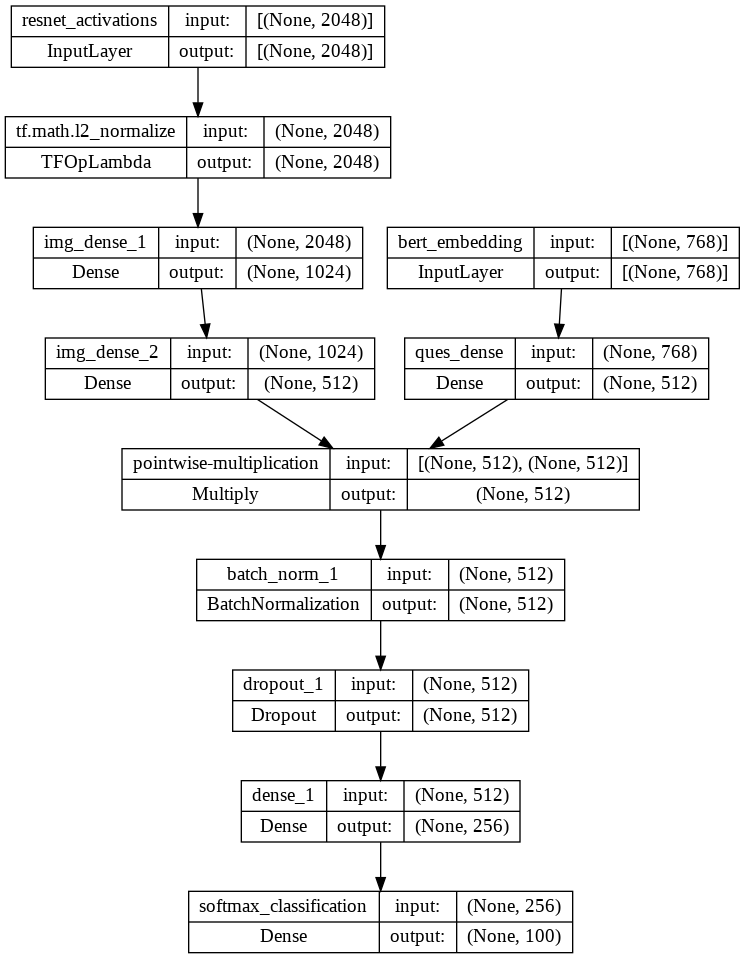

In [ ]:
dot_img_file = '/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-2-VQA/model_images/model_2.png'
plot_model(model_2, to_file=dot_img_file, show_shapes=True)

In [ ]:
model_2 = load_model('/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-2-VQA/model_save/best_model_2.h5')

In [ ]:
loss, accuracy = model_2.evaluate(val_dataloader, verbose=0)

In [ ]:
print("Val Loss: {}".format(loss))
print("Val Accuracy: {}".format(accuracy))

Val Loss: 1.4785834550857544
Val Accuracy: 0.43760278820991516


In [ ]:
# %tensorboard --logdir '/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-2-VQA/model_logs/model_2/'

Tensorboard logs: ( orange- Train, blue- Val )

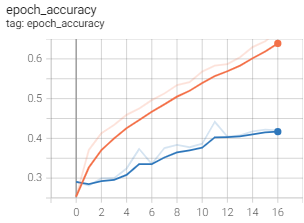

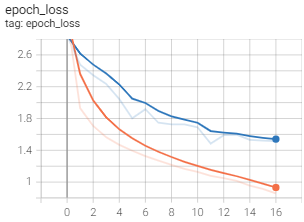

### Sample Prediction:

In [ ]:
y_pred_val = model_2.predict([np.asarray([val_dataset[1000][0]]), np.asarray([val_dataset[1000][1]])])
y_pred_val = ohe.inverse_transform(tf.one_hot(tf.argmax(y_pred_val, axis=1), depth=len(ohe.categories_[0])))[0][0]

1/1 [==============================] - 0s 116ms/step


(-0.5, 499.5, 374.5, -0.5)

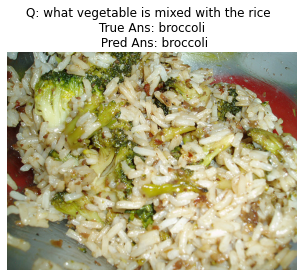

In [ ]:
plt.figure()
plt.title(
    f"Q: {val_df.iloc[1000]['question']} \n True Ans: {val_df.iloc[1000]['multiple_choice_answer']} \n Pred Ans: {y_pred_val}")
img = mpimg.imread(val_df.iloc[1000]['image_path'])
plt.imshow(img)
plt.axis('off')

# Conclusion:

In [ ]:
x = PrettyTable()

x.field_names = ["Model", "Model-Type", "Val loss", "Val Accuracy"]

x.add_row([ "Model 1", "VGG(Image) & GLOVE(Text)", 1.391, 0.438])
x.add_row([ "Model 2", "ResNet(Image) & BERT(Text)", 1.478, 0.437])

print(x)

+---------+----------------------------+----------+--------------+
|  Model  |         Model-Type         | Val loss | Val Accuracy |
+---------+----------------------------+----------+--------------+
| Model 1 |  VGG(Image) & GLOVE(Text)  |  1.391   |    0.438     |
| Model 2 | ResNet(Image) & BERT(Text) |  1.478   |    0.437     |
+---------+----------------------------+----------+--------------+


Considering that the model was trained for just ~25 epochs and with limited fine tuning due to resource contraints, the results obtained above are reasonable for the vanilla VQA architecture chosen.

The multi-modal complexity of the task makes the it hard and a compelling “[AI-Complete](https://en.wikipedia.org/wiki/AI-complete)” task.

The results obtained in the research paper considering the task as a 1000-class classification problem was 57.75. (Src: [link](https://arxiv.org/pdf/1505.00468.pdf))

## Accuracy of models for each answer_type:

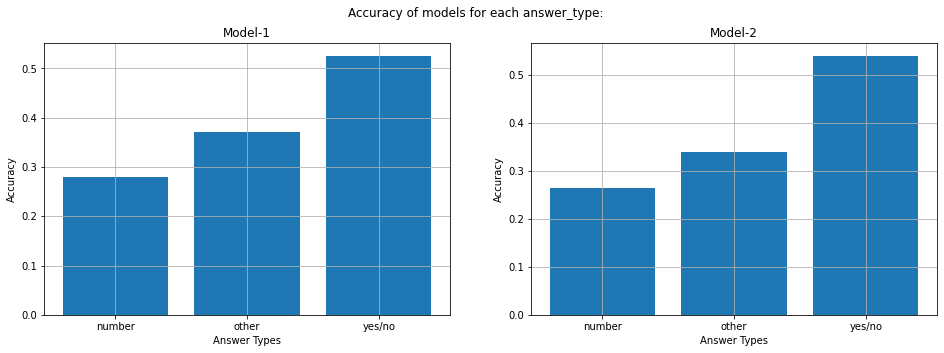

In [ ]:
# Model-1
model_1_acc = {}

for ans_type in np.unique(train_df['answer_type']):
    val_dataset  = Dataset_model_1(
        val_df[val_df['answer_type'] == ans_type], tknizr, glove_embedding_layer, MAX_SEQUENCE_LENGTH, 
        vgg_featurizer, IMG_TARGET_SIZE, ohe
    )
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle_every_epoch=True)
    _, model_1_acc[ans_type] = model_1.evaluate(val_dataloader, verbose=0)

# Model-2
model_2_acc = {}

for ans_type in np.unique(train_df['answer_type']):
    val_dataset  = Dataset_model_2(
        val_df[val_df['answer_type'] == ans_type], tokenizer, bert_featurizer, MAX_SEQUENCE_LENGTH, 
        resnet50_featurizer, IMG_TARGET_SIZE, ohe
    )
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle_every_epoch=True)
    _, model_2_acc[ans_type] = model_2.evaluate(val_dataloader, verbose=0)

# plotting
plt.figure(figsize=(16,5))
for i, (key, val) in enumerate({"Model-1": model_1_acc, "Model-2": model_2_acc}.items()):
    plt.subplot(1,2,i+1)
    plt.grid()
    plt.title(key)
    ans_types = np.unique(train_df['answer_type'])
    plt.xlabel("Answer Types")
    acc = [val[typ] for typ in ans_types]
    plt.ylabel("Accuracy")
    plt.bar(ans_types, acc)
plt.suptitle("Accuracy of models for each answer_type:")
plt.show()

## How good is the vanilla VQA architecture?:

As seen above, the models performed well on certain answer_types and not so well on others. This could be due to biases in the data and due to over representation of a few answer categories among the k(100) answers choices.

Also, from the results published in the [paper](https://arxiv.org/pdf/1505.00468.pdf) it should be noted that the question-only model performed reasonable well by exploiting the biases in the questions-answers(data) and including the image features improved the model accuracy just by ~8%.

Reference: [link](https://blog.allenai.org/vanilla-vqa-adcaaaa94336#:~:text=How%20well%20do%20these%20simple%20models%20perform%20%3F)

# Future Work:

- Fine tune the model, train for larger epochs and make use of the sequence information from bert layer.
- Run on larger sample of the dataset with higher image resolutions and for higher number of answer choices in the problem('k').
- While performing the above two points use only the top-k most frequent words from the questions instead of the full vocabulary for featurization. This was also done in the referred VQA paper.
- Try out other architectures which incorporate attention mechanisms that focus better on the relevant features of the image for a given question. Few such architectures are:
    - [Hierarchical Question-Image Co-Attention for Visual Question Answering](https://arxiv.org/pdf/1606.00061.pdf).
    - [Stacked Attention Networks for Image Question Answering](https://arxiv.org/pdf/1511.02274.pdf).
etc